In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
data = pd.read_csv("Labelled Yelp Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359052 entries, 0 to 359051
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   User_id     359052 non-null  int64 
 1   Product_id  359052 non-null  int64 
 2   Rating      359052 non-null  int64 
 3   Date        359052 non-null  object
 4   Review      359052 non-null  object
 5   Label       359052 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 16.4+ MB


In [3]:
to_drop = ["User_id","Product_id","Rating", "Date"]
data = data.drop(data[to_drop], axis=1)
data.rename(columns = {"Label":"Target", "Review":"Text"}, inplace = True)
data.head()

,Text,Target
0,The food at snack is a selection of popular Gr...,-1
1,This little place in Soho is wonderful. I had ...,-1
2,ordered lunch for 15 from Snack last Friday. Â...,-1
3,This is a beautiful quaint little restaurant o...,-1
4,Snack is great place for a Â casual sit down l...,-1


Text(0, 0.5, 'Number of Data points')

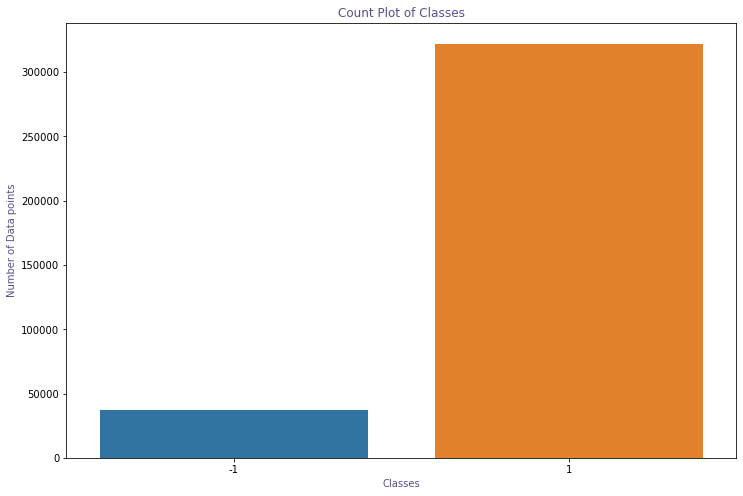

In [5]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"])
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [60]:
data.head()

,Text,Target,Text_clean
0,The food at snack is a selection of popular Gr...,-1,food snack select popular greek dish appet tra...
1,This little place in Soho is wonderful. I had ...,-1,littl place soho wonder lamb sandwich glass wi...
2,ordered lunch for 15 from Snack last Friday. Â...,-1,order lunch snack last friday time noth miss ...
3,This is a beautiful quaint little restaurant o...,-1,beauti quaint littl restaur pretti street your...
4,Snack is great place for a Â casual sit down l...,-1,snack great place casual sit lunch especi cold...


In [70]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,359052.0,0.794542,0.607210,-1.0,1.0,1.0,1.0,1.0
message_len,359052.0,116.625634,106.947227,1.0,45.0,86.0,154.0,1473.0
No_of_Characters,359052.0,636.972962,584.909263,1.0,246.0,470.0,835.0,5356.0
No_of_Words,359052.0,137.173231,125.239278,1.0,53.0,102.0,180.0,1611.0
No_of_sentence,359052.0,8.504492,6.887553,1.0,4.0,7.0,11.0,103.0


In [7]:
data[data['No_of_sentence'] == 103]['Text']

213422    The little halal food cart that could. Feed Ne...
Name: Text, dtype: object

<Figure size 864x576 with 0 Axes>

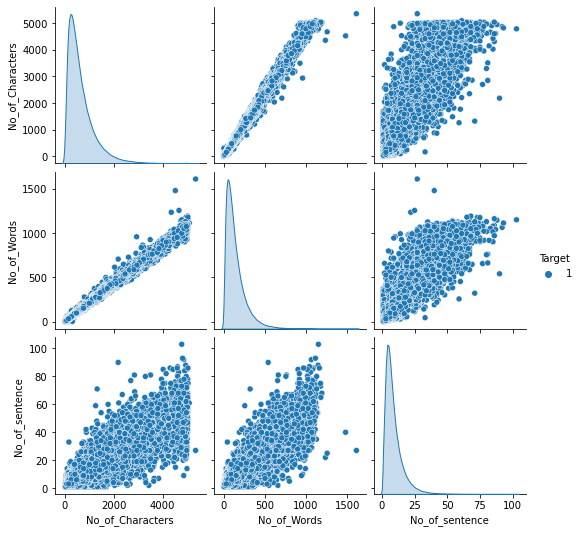

In [11]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data[data['Target'] == 1], hue="Target")
plt.show(fg)

<Figure size 864x576 with 0 Axes>

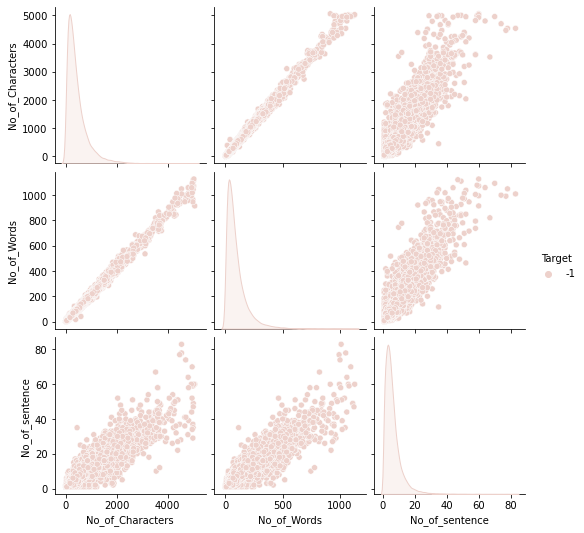

In [12]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data[data['Target'] == -1], hue="Target")
plt.show(fg)

In [4]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('â\xa0', '', text)
    return text

In [5]:
data['Text_clean'] = data['Text'].apply(clean_text)
data.head()

,Text,Target,Text_clean
0,The food at snack is a selection of popular Gr...,-1,the food at snack is a selection of popular gr...
1,This little place in Soho is wonderful. I had ...,-1,this little place in soho is wonderful i had a...
2,ordered lunch for 15 from Snack last Friday. Â...,-1,ordered lunch for from snack last friday on t...
3,This is a beautiful quaint little restaurant o...,-1,this is a beautiful quaint little restaurant o...
4,Snack is great place for a Â casual sit down l...,-1,snack is great place for a casual sit down lun...


In [6]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
data['Text_clean'] = data['Text_clean'].apply(remove_stopwords)
data.head()

,Text,Target,Text_clean
0,The food at snack is a selection of popular Gr...,-1,food snack selection popular greek dishes appe...
1,This little place in Soho is wonderful. I had ...,-1,little place soho wonderful lamb sandwich glas...
2,ordered lunch for 15 from Snack last Friday. Â...,-1,ordered lunch snack last friday time nothing ...
3,This is a beautiful quaint little restaurant o...,-1,beautiful quaint little restaurant pretty stre...
4,Snack is great place for a Â casual sit down l...,-1,snack great place casual sit lunch especially ...


In [7]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [8]:
data['Text_clean'] = data['Text_clean'].apply(stemm_text)
data.head()

,Text,Target,Text_clean
0,The food at snack is a selection of popular Gr...,-1,food snack select popular greek dish appet tra...
1,This little place in Soho is wonderful. I had ...,-1,littl place soho wonder lamb sandwich glass wi...
2,ordered lunch for 15 from Snack last Friday. Â...,-1,order lunch snack last friday time noth miss ...
3,This is a beautiful quaint little restaurant o...,-1,beauti quaint littl restaur pretti street your...
4,Snack is great place for a Â casual sit down l...,-1,snack great place casual sit lunch especi cold...


In [32]:
from collections import Counter

words = data[data.Target==1].Text_clean.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('place', 229880), ('good', 226868), ('food', 221508), ('great', 154686), ('like', 150115), ('order', 140624), ('get', 130067), ('go', 123770), ('one', 120000), ('time', 119570), ('realli', 114224), ('friend', 108424), ('wait', 105114), ('tri', 103946), ('servic', 96325), ('back', 96074), ('love', 93487), ('delici', 92065), ('restaur', 89843), ('would', 88730), ('also', 87703), ('come', 83798), ('dish', 75558), ('tabl', 74919), ('best', 73685), ('sauc', 73076), ('nice', 69170), ('chicken', 68679), ('got', 68252), ('tast', 68117), ('us', 67195), ('even', 66979), ('fri', 66901), ('ive', 66524), ('eat', 65881), ('make', 65545), ('menu', 65403), ('well', 65227), ('littl', 64809), ('definit', 64288), ('came', 62866), ('pizza', 60565), ('perfect', 60418), ('flavor', 58913), ('amaz', 57461), ('want', 56305), ('pork', 55439), ('pretti', 54498), ('drink', 54458), ('much', 52205)]


In [33]:
words = data[data.Target==-1].Text_clean.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('food', 25277), ('place', 22028), ('good', 17606), ('great', 17234), ('go', 11939), ('servic', 11244), ('time', 11130), ('like', 10496), ('restaur', 9986), ('get', 9833), ('friend', 9671), ('one', 9344), ('order', 9257), ('love', 9229), ('wait', 8862), ('back', 8384), ('realli', 8152), ('tri', 7910), ('best', 7819), ('delici', 7195), ('would', 7166), ('us', 6563), ('pizza', 6357), ('tabl', 5920), ('come', 5835), ('even', 5757), ('amaz', 5752), ('nice', 5729), ('also', 5688), ('make', 5381), ('eat', 5375), ('staff', 5150), ('price', 5076), ('menu', 5038), ('tast', 4829), ('well', 4809), ('ive', 4674), ('dish', 4598), ('alway', 4489), ('want', 4472), ('drink', 4438), ('went', 4391), ('recommend', 4381), ('chicken', 4361), ('peopl', 4325), ('definit', 4317), ('night', 4275), ('bar', 4144), ('experi', 4131), ('dinner', 4107)]


In [9]:
x = data['Text_clean']
y = data['Target']

print(len(x), len(y))

359052 359052


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=121)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

269289 269289
89763 89763


In [ ]:
# bow

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [12]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
# tfidf

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

x_train_tfidf

<269289x166606 sparse matrix of type '<class 'numpy.float64'>'
	with 13408461 stored elements in Compressed Sparse Row format>

In [ ]:
# naive bayes with bow

In [54]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.8856767264908704


array([[  767,  8580],
       [ 1682, 78734]])

In [51]:
# print message text for false negatives (spam incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==-1)]
x_test[y_pred_class > y_test]

110201    good valu good food food buddi duck meatloaf w...
328919    place went casellula crowd backup first choic ...
285634    went weekendsecond time food great place small...
157269    food good understand peopl wait line weekend m...
39688     great tast japan noodl high qualiti soup make ...
                                ...                        
50506     well done food reason price cook skill ingredi...
110235    fabul flew san antonio celebr son birthday gir...
50483     intrigu menu mani interest choicesappet shrimp...
337609            great burger limit menu kid  split burger
191248    wednesday night blizzard  figur ever go tri di...
Name: Text_clean, Length: 8580, dtype: object

In [52]:
# print message text for false positives (ham incorrectly classifier)
x_test[y_pred_class < y_test]

215323    nice atmospher good vibe good beer food realli...
105019    one two three four  declar wine bar war norths...
168628    first visit zizi limona though roommat bunch t...
321375    last straw last night fouryear anniversari cel...
156975    bogota great communic custom provid ever possi...
                                ...                        
33313     place get  star instead  becaus last dine expe...
278853    incred disappoint experi everyth pretti much w...
142681    good foodbut guy serious teenag rock loud offe...
1556      made reserv birthday  week prior easi  blast n...
259114    your italianamerican youv italian store old ne...
Name: Text_clean, Length: 1682, dtype: object

In [ ]:
# naive bayes with bow -- ngram_range=(1,2), min_df=0.1, max_df=0.7

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2), min_df=0.1, max_df=0.7)
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

nb.fit(x_train_dtm, y_train)

y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.8861780466339138


array([[  266,  9081],
       [ 1136, 79280]])

In [ ]:
# naive bayes with bow -- ngram_range=(1,2), min_df=0.1, max_df=0.65

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2), min_df=0.1, max_df=0.65)
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

nb.fit(x_train_dtm, y_train)

y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.8861780466339138


array([[  266,  9081],
       [ 1136, 79280]])

In [ ]:
# naive bayes with bow, tf-idf

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

0.8961376068090416


array([[   27,  9320],
       [    3, 80413]])

In [ ]:
# logistic regression with bow

In [49]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

logreg.fit(x_train_dtm, y_train)
y_pred_class = logreg.predict(x_test_dtm)
y_pred_prob = logreg.predict_proba(x_test_dtm)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)


0.8919153771598543


array([[  254,  9093],
       [  609, 79807]])

In [ ]:
# logistic regression with bow, tf-idf

In [51]:
pipe_1 = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', LogisticRegression(solver='liblinear'))])
pipe_1.fit(x_train, y_train)

y_pred = pipe_1.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

0.8954246181611577


array([[   89,  9258],
       [  129, 80287]])

In [ ]:
# random forest with bow

In [43]:
from sklearn.ensemble import RandomForestClassifier

RFC_0 = RandomForestClassifier()

RFC_0.fit(x_train_dtm, y_train)

y_pred_class = RFC_0.predict(x_test_dtm)
y_pred_prob = RFC_0.predict_proba(x_test_dtm)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.8955917248755055


array([[  168,  9179],
       [  193, 80223]])

In [ ]:
# random forest with bow tfidf

In [18]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()

RFC.fit(x_train_tfidf, y_train)

y_pred_class = RFC.predict(x_test_tfidf)
y_pred_prob = RFC.predict_proba(x_test_tfidf)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.8958702360660852


array([[  141,  9206],
       [  141, 80275]])

In [ ]:
# xgboost with bow and tfidf

In [19]:
import xgboost as xgb

XGB = xgb.XGBClassifier()

XGB.fit(x_train_tfidf, y_train)
y_pred_class = XGB.predict(x_test_tfidf)
y_pred_prob = XGB.predict_proba(x_test_tfidf)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

/Users/vics/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.895680848456491


array([[   48,  9299],
       [   65, 80351]])

In [21]:
XGB = xgb.XGBClassifier(learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=True,
        eval_metric='auc')

XGB.fit(x_train_tfidf, y_train)
y_pred_class = XGB.predict(x_test_tfidf)
y_pred_prob = XGB.predict_proba(x_test_tfidf)[:, 1]
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

/Users/vics/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8958702360660852


array([[    4,  9343],
       [    4, 80412]])

In [29]:
text_string = []
with open('mid_texts_string.txt', 'r', encoding='utf-8') as f:
    lines = f.read()
    line = lines.split(',')
    text_string.append(line)
text_string = pd.DataFrame(text_string[0])


In [33]:
text_string.rename(columns = {0:"Text"}, inplace = True)
text_string.head()

,Text
0,hate people rate place base experience competi...
1,large little meat lot noodles though could ing...
2,food pretty good wish options variety menu var...
3,overcook noodles fresh herbs include sawgrass ...
4,first place know come austin find tasty fast q...


In [36]:
text_dtm = vect.transform(text_string['Text'])


In [37]:
text_tfidf = tfidf_transformer.transform(text_dtm)

In [41]:
text_string['XGB_tfidf_y'] = XGB.predict(text_tfidf)
text_string['XGB_tfidf_y'].value_counts()

 1    69830
-1        2
Name: XGB_tfidf_y, dtype: int64

In [46]:
text_string['RFC_tfidf_y'] = RFC.predict(text_tfidf)
text_string['RFC_tfidf_y'].value_counts()

 1    69808
-1       24
Name: RFC_tfidf_y, dtype: int64

In [47]:
text_string['RFC_bow_y'] = RFC_0.predict(text_dtm)
text_string['RFC_bow_y'].value_counts()

 1    69709
-1      123
Name: RFC_bow_y, dtype: int64

In [56]:
text_string['LOG_bow_y'] = logreg.predict(text_dtm)
text_string['LOG_bow_y'].value_counts()

 1    67423
-1     2409
Name: LOG_bow_y, dtype: int64

In [53]:
text_string['LOG_tfidf_y'] = pipe_1.predict(text_string['Text'])
text_string['LOG_tfidf_y'].value_counts()

 1    69800
-1       32
Name: LOG_tfidf_y, dtype: int64

In [57]:
text_string['NB_bow_y'] = nb.predict(text_dtm)
text_string['NB_bow_y'].value_counts()

 1    48517
-1    21315
Name: NB_bow_y, dtype: int64

In [58]:
text_string

,Text,Text_clean,XGB_tfidf_y,RFC_tfidf_y,RFC_bow_y,LOG_bow_y,LOG_tfidf_y,NB_bow_y
0,hate people rate place base experience competi...,hate people rate place base experience competi...,1,1,1,1,1,1
1,large little meat lot noodles though could ing...,large little meat lot noodles though could ing...,1,1,1,1,1,1
2,food pretty good wish options variety menu var...,food pretty good wish options variety menu var...,1,1,1,1,1,1
3,overcook noodles fresh herbs include sawgrass ...,overcook noodles fresh herbs include sawgrass ...,1,1,1,1,1,1
4,first place know come austin find tasty fast q...,first place know come austin find tasty fast q...,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
69827,ever since start build place know would defini...,ever since start build place know would defini...,1,1,1,1,1,-1
69828,cute place open today pop open go much line fi...,cute place open today pop open go much line fi...,1,1,1,1,1,1
69829,food pretty good service need improvement try ...,food pretty good service need improvement try ...,1,1,1,1,1,1
69830,arlene sweet accommodate good people check,arlene sweet accommodate good people check,1,1,1,1,1,1
